In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [54]:
# Download the wine dataset from the UCI Machine Learning Repository
df_wine = pd.read_csv('dataset1.csv')

In [55]:
# Show the first five rows of the dataset
df_wine.head()

,Col7,Col5,Col2,Col4,Col8,Col3,Col6,Col1,Target
0,20.8,0.733,48,9,22,120,72,56,0
1,32.0,0.444,42,1,29,100,66,196,0
2,34.8,0.217,24,1,45,112,80,132,0
3,31.0,0.874,21,0,16,113,80,0,0
4,26.2,0.313,41,6,30,80,66,0,0


In [56]:
# Show the shape of the dataset
df_wine.shape

(768, 9)

In [57]:
# Splitting the dataset into features and target variable
X, y = df_wine.iloc[:, 0:-1].values, df_wine.iloc[:, -1].values # Target variable is the first column

In [58]:
# Splitting the dataset into training and test sets
# stratify=y makes sure that the training and test datasets have the same class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) # 30% test data

In [59]:
# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [60]:
# Compute one mean vector for each label
mean_vecs = []
for label in range(0, 2):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 0: [-0.23105074 -0.11780909 -0.17445529 -0.17908433 -0.06340531 -0.33813841
 -0.04259687 -0.0632112 ]

MV 1: [-0.23105074 -0.11780909 -0.17445529 -0.17908433 -0.06340531 -0.33813841
 -0.04259687 -0.0632112 ]



In [61]:
# Compute the within-class scatter matrix
d = 8  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 8x8


In [62]:
# Calculate the between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 8 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T)

print('Between-class scatter matrix: ' f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 8x8


In [63]:
# Calculate the eigenvalues and eigenvectors of the matrix 𝑺𝑊−1·𝑺𝐵 :
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [64]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

23.41712169788517
3.62732330478807e-15
3.62732330478807e-15
9.161622578138782e-16
7.308567145914857e-16
7.308567145914857e-16
5.626389334564171e-16
2.319562329203529e-16


In [65]:
# Construct the projection matrix 
# In this case, we will reduce the high-dimensional feature space to a 2-dimensional feature subspace
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.47804699  0.17605448]
 [ 0.20271599 -0.75604331]
 [ 0.11628228  0.06832159]
 [ 0.31606456  0.07662311]
 [ 0.13758511 -0.16648684]
 [ 0.71722384  0.12951147]
 [-0.2123238  -0.09892752]
 [-0.19631056 -0.09923016]]


In [66]:
# Transform the first element of the training dataset using the projection matrix
X_train_std[0].dot(w)

array([-1.42055563, -0.08252065])

In [67]:
# Transform the entire training dataset using the projection matrix
X_train_lda = X_train_std.dot(w)

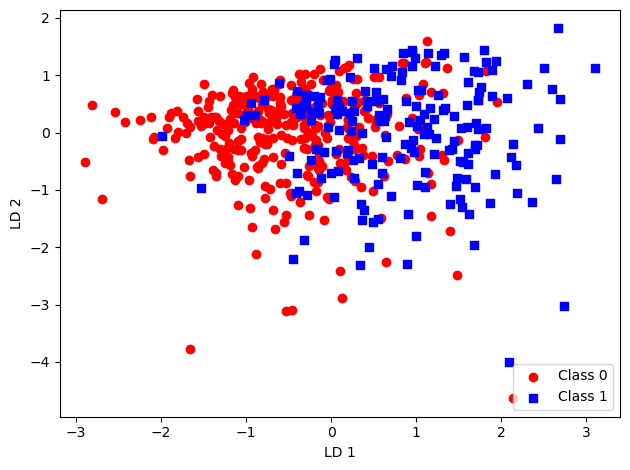

In [68]:
# Visualize the transformed  training dataset in a two-dimensional scatterplot
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [69]:
# Auxiliar function to plot the decision regions
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

In [70]:
# scikit-learn
# Initializing the LDA transformer
lda = LDA(n_components=1)

# Initializing the logistic regression estimator:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs') # ovr = One-vs-Rest, lbfgs = Limited-memory Broyden-Fletcher-Goldfarb-Shanno

# Dimensionality reduction
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# Fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_lda, y_train)

# Plotting the decision regions in the reduced space for the training dataset
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

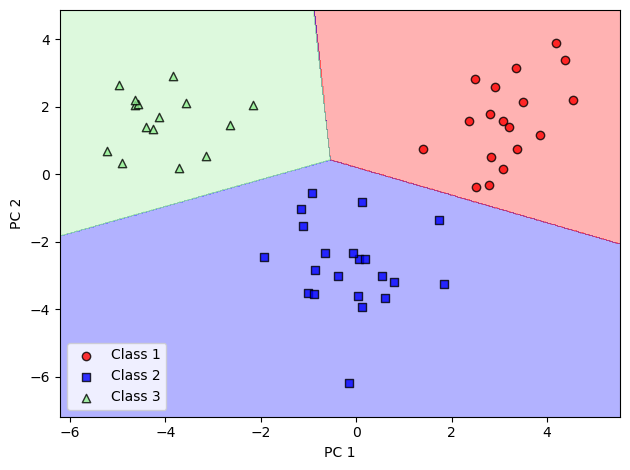

In [23]:
# scikit-learn
# Plotting the decision regions in the reduced space for the test dataset
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()